# Movie Recommender - FLICKSENSE
# Gautam Phuyal -- 19937PG
### Dataset - Movielens (ml-latest-small)
### Dataset Link: https://grouplens.org/datasets/movielens/
<br>


## Objective
To develop an app that allows movie searching and recommendations using the Movielens dataset. The approach involves:
- **Item-to-Item Collaborative Filtering:** Identifies similar movies based on user ratings.
- **Content-Based Recommender:** Utilizes TF-IDF Vectorization on genre and title.
- **User-Specific Recommendations:** Tailors movie suggestions for individual users.
- A **Hybrid Model** combining the above strategies.

## Tech Stack
**Python Libraries:**
- Pandas
- Matplotlib
- Seaborn
- Numpy
- Sklearn
- Scipy

**API:** 
- FastAPI


### About the Dataset - Metadata

1. The Movielens dataset encompasses 5-star rating and free-text tagging activities from [MovieLens](http://movielens.org).
2. It includes 4 CSV files:
   - `ratings.csv`: Contains all user ratings, ranging from 0.5 to 5 in 0.5 increments.
   - `tags.csv`: Holds all user-generated tags.
   - `movies.csv`: Details movie titles and their associated genres.
   - `links.csv`: Provides identifiers linking to other movie data sources.
3. Key Figures:
   - The dataset features 100,836 ratings.
   - It comprises 9,742 movies.
   - It includes 3,683 tags.
   - There are 6,190 users, with IDs consistent across ratings and tags.
   - Movie IDs are consistent across ratings, tags, movies, and links.
   - Genres are listed in a pipe-separated format.
   - Tags consist of single words or short phrases generated by users about movies.


### Importing the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import sklearn

### Loading the datasets


In [2]:
df_links = pd.read_csv("links.csv")
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")
df_tags = pd.read_csv("tags.csv")

### Exploring movies.csv 

In [3]:
df_movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_movies.shape

(9742, 3)

In [6]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
#converting pipe separated genres into a list

df_movies['genres'] = df_movies.genres.str.split('|')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [8]:
# here we extract year from title
df_movies['released'] =df_movies['title'].str.extract('.*\((.*)\).*',expand = False)
df_movies['title']=df_movies.title.str.slice(0,-7)

In [9]:
df_movies[df_movies.movieId==171749]

,movieId,title,genres,released
9518,171749,Death Note: Desu nôto (200,[(no genres listed)],2006–2007


In [10]:
df_movies.released.value_counts()

2002         311
2006         295
2001         294
2007         284
2000         283
            ... 
1921           1
1902           1
1915           1
1903           1
2006–2007      1
Name: released, Length: 107, dtype: int64

### Exploring ratings.csv 

In [11]:
df_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [12]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
df_ratings.shape

(100836, 4)

In [14]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [15]:
df_ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

### Exploring tags.csv

In [16]:
df_tags.columns

Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

In [17]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [18]:
df_tags.shape

(3683, 4)

In [19]:
df_tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

### Exploring links.csv

In [20]:
df_links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [21]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [22]:
df_links.shape

(9742, 3)

In [23]:
df_links.isnull().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

### Merging the movies and ratings dfs over common movieID to get one table

In [24]:
movies_ratings=pd.merge(left=df_ratings,right=df_movies,on='movieId')
movies_ratings = movies_ratings[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]
movies_ratings.head()

,userId,movieId,title,genres,rating,timestamp
0,1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,964982703
1,5,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,847434962
2,7,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1106635946
3,15,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",2.5,1510577970
4,17,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1305696483


In [25]:
movies_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   title      100836 non-null  object 
 3   genres     100836 non-null  object 
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


### Visualizing the average ratings of movies to see if there is any valuable insight

In [26]:
# grouping the movies based on average rating
average_movie_rating = movies_ratings.groupby('title')['rating'].mean().sort_values(ascending=False)
average_movie_rating.head()

title
Reform School Girls                           5.0
Return to Treasure Island                     5.0
Enter the Void                                5.0
Entertaining Angels: The Dorothy Day Story    5.0
SORI: Voice from the Heart                    5.0
Name: rating, dtype: float64

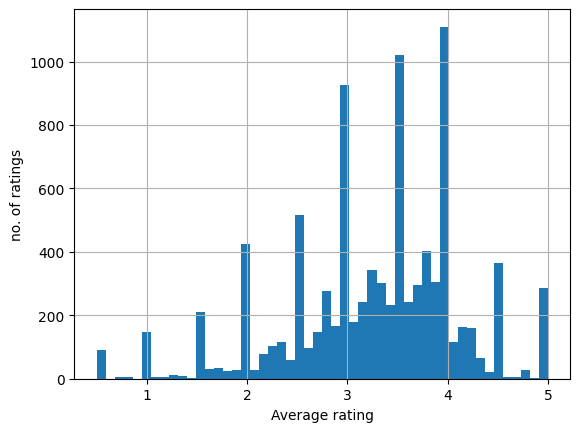

In [27]:
average_movie_rating.hist(bins=50)
plt.xlabel('Average rating')
plt.ylabel('no. of ratings')
plt.show()

### Plot showing the number of movies in each genre

/var/folders/72/rbkg46ms4w34b7kqvl3yskw80000gn/T/ipykernel_17192/1593841124.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_genres=pd.get_dummies(df_movies['genres'].apply(pd.Series).stack()).sum(level=0)


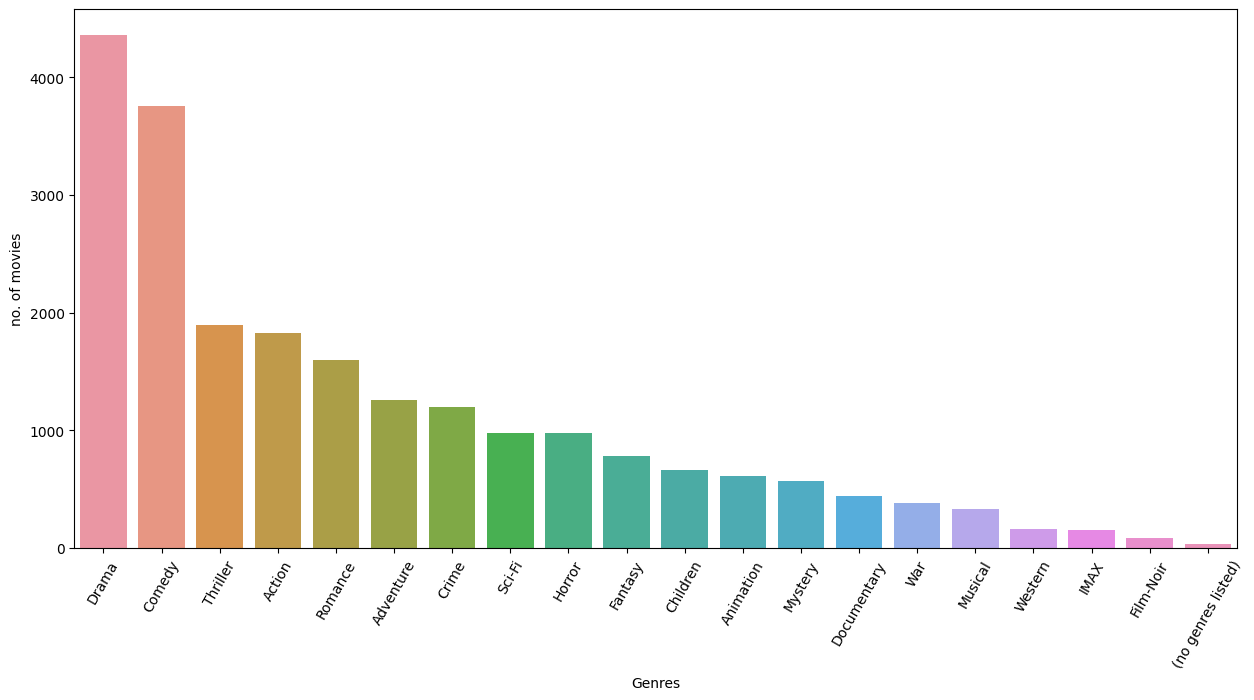

In [29]:
df_genres=pd.get_dummies(df_movies['genres'].apply(pd.Series).stack()).sum(level=0)
generes = ['Action','Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary','Drama', 'Fantasy', 
           'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
plt.figure(figsize=(15,7))
genere_counts = df_genres.sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xlabel('Genres')
plt.ylabel('no. of movies')
plt.xticks(rotation=60);


### Checking what is the distribution of numebr of users who are rating movies with the numer of movies


In [30]:
count_userid = movies_ratings.groupby('title')['userId'].count().sort_values(ascending=False)
count_userid

title
Forrest Gump                          329
Shawshank Redemption, The             317
Pulp Fiction                          307
Silence of the Lambs, The             279
Matrix, The                           278
                                     ... 
Electroma                               1
Electra Glide in Blue                   1
Playing It Cool                         1
Elections Day                           1
À nous la liberté (Freedom for Us)      1
Name: userId, Length: 9445, dtype: int64

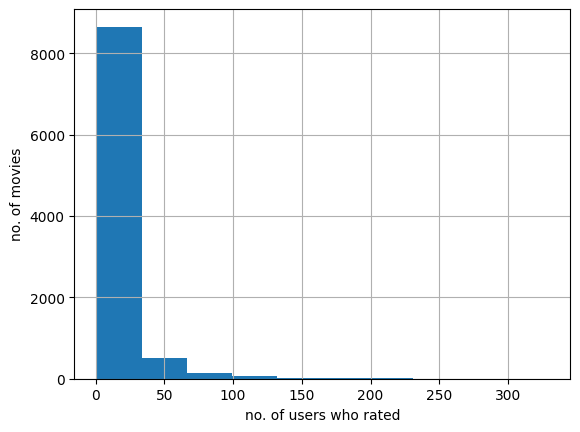

In [31]:
count_userid.hist()
plt.xlabel('no. of users who rated')
plt.ylabel('no. of movies')
plt.show()

### Visualising yearly movie count

In [32]:
viz=df_movies.dropna()
print(viz.shape)
viz[viz.movieId==171749]

(9730, 4)


,movieId,title,genres,released
9518,171749,Death Note: Desu nôto (200,[(no genres listed)],2006–2007


In [33]:
viz=viz.drop(9518)

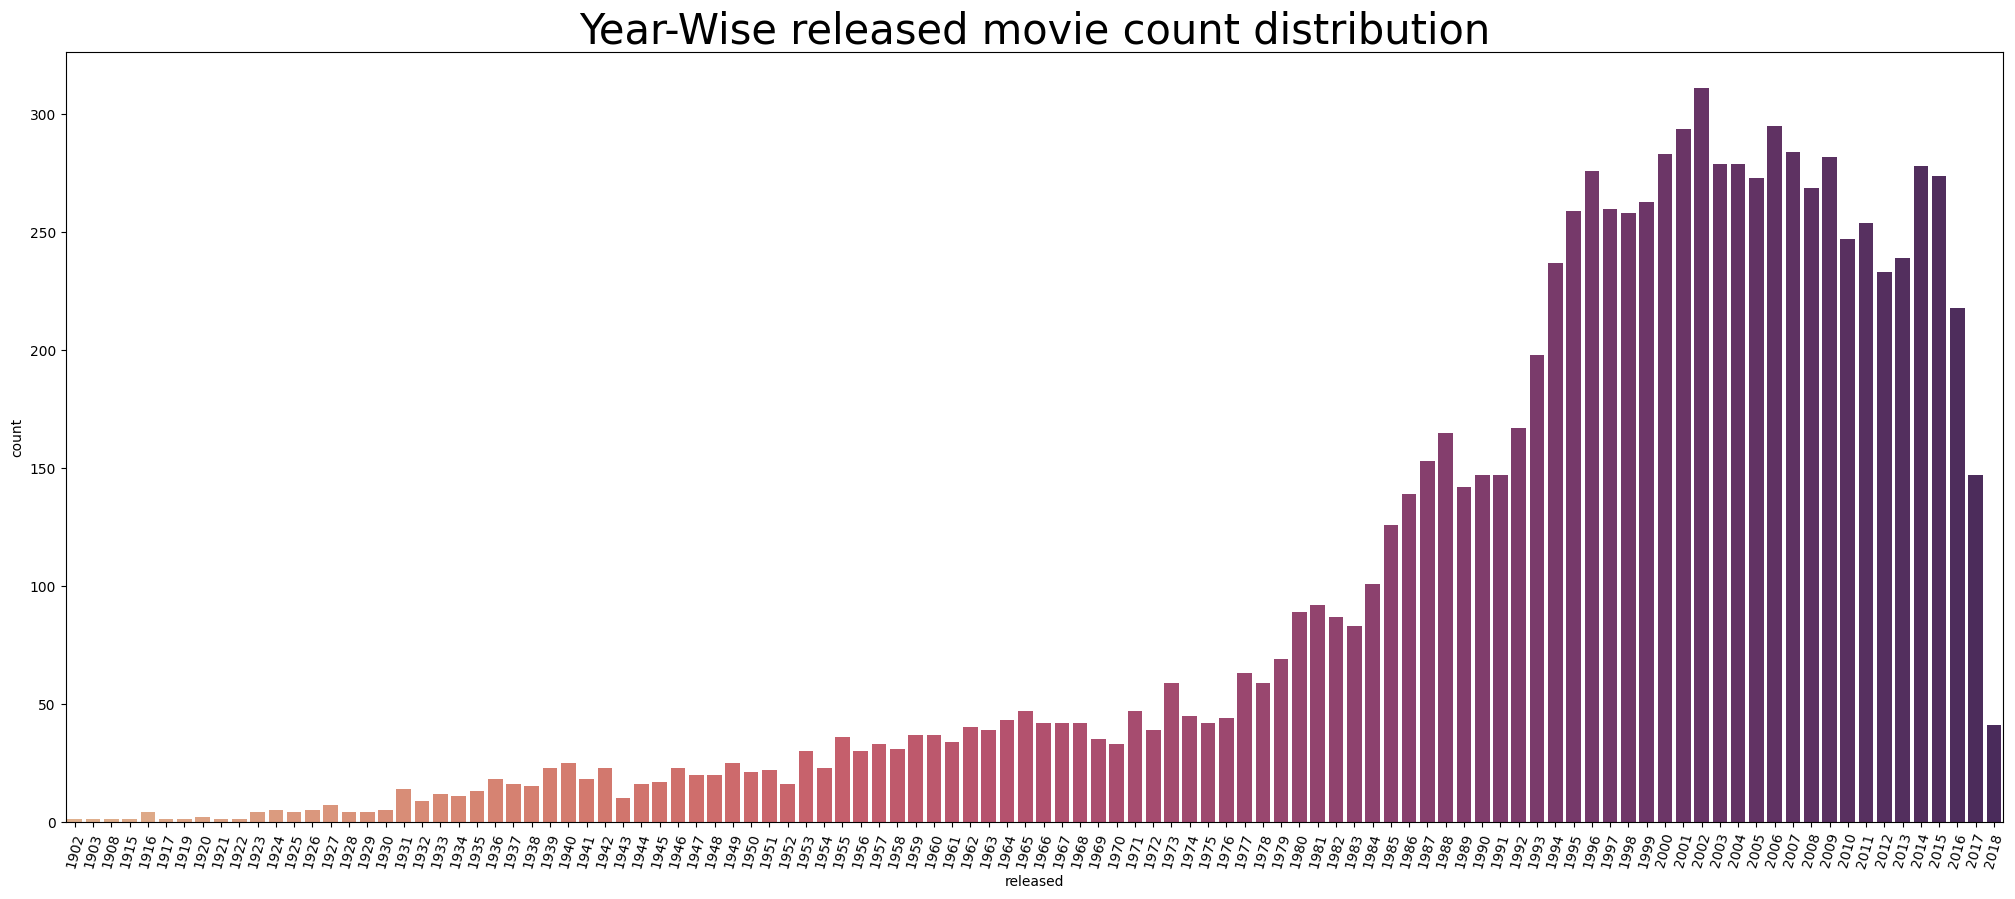

In [34]:
viz['released'] =viz.released.astype(int)
plt.figure(figsize=(25, 10))
sns.countplot(x='released',data=viz, palette="flare")
plt.xticks(rotation=75, fontsize = 10)
plt.title("Year-Wise released movie count distribution",color='black',fontsize = 30)
plt.show()

### Top 15 most rated movies

In [35]:
# count of ratings
count_of_ratings = df_ratings[['movieId' , 'userId']].groupby('movieId').count()
count_of_ratings.rename(columns={'userId' : 'Count of Ratings'}, inplace=True)

# Joining count of ratings with movies names
# top 25 most rated movies of all time
movie_rating_counts = df_movies[['movieId','title']].merge(count_of_ratings, on='movieId')

movie_rating_counts.sort_values('Count of Ratings' , ascending=False)[:15] [['title' , 'Count of Ratings']]

,title,Count of Ratings
314,Forrest Gump,329
277,"Shawshank Redemption, The",317
257,Pulp Fiction,307
510,"Silence of the Lambs, The",279
1938,"Matrix, The",278
224,Star Wars: Episode IV - A New Hope,251
418,Jurassic Park,238
97,Braveheart,237
507,Terminator 2: Judgment Day,224
461,Schindler's List,220


### Distribution of number of movies with number of ratings

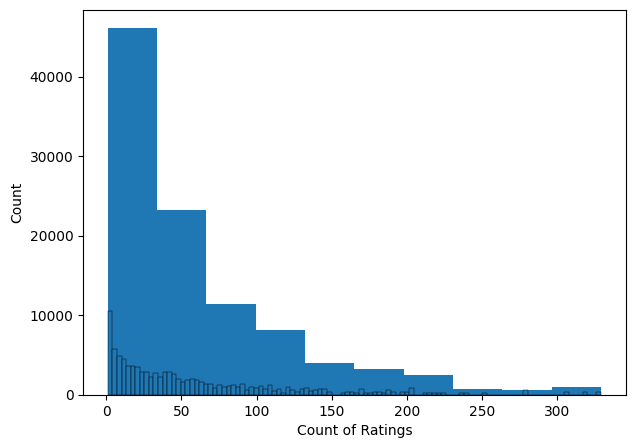

In [36]:
movies_rat = movies_ratings.merge(movie_rating_counts[['movieId' , 'Count of Ratings']])

plt.figure(figsize=(7,5))
plt.hist(movies_rat['Count of Ratings'])
sns.histplot(data=movies_rat, x="Count of Ratings")
plt.show()

### Finding the top 15 users based on no. of ratings and top 15 movies based on rating

In [37]:
top_users_g = df_ratings.groupby('userId')['rating'].count()
top_users = top_users_g.sort_values(ascending=False)[:15]
top_movies_g = df_ratings.groupby('movieId')['rating'].count()
top_movies = top_movies_g.sort_values(ascending=False)[:15]
top_users_movies = df_ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_users_movies = top_users_movies.join(top_movies, rsuffix='_r', how='inner', on='movieId')
df_ratings.shape, top_users_movies.shape

((100836, 4), (211, 6))

In [38]:
top_users_movies.userId.unique(), top_users_movies.movieId.unique()

(array([ 68, 182, 249, 274, 288, 307, 380, 414, 448, 474, 599, 603, 606,
        610, 387]),
 array([   1,   50,  110,  260,  296,  318,  356,  480,  527,  589,  593,
        1196, 2571, 2858, 2959]))

### Making a pivot table to map userID with movieID 


# Building the Models

## 1) Item to Item Collaborative Filtering

In [39]:
numberOf_user_voted_for_movie = pd.DataFrame(df_ratings.groupby('movieId')['rating'].agg('count'))
numberOf_user_voted_for_movie.reset_index(level = 0,inplace = True)
numberOf_user_voted_for_movie.head()

,movieId,rating
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [40]:
numberOf_movies_voted_by_user = pd.DataFrame(df_ratings.groupby('userId')['rating'].agg('count'))     
numberOf_movies_voted_by_user.reset_index(level = 0,inplace = True)
numberOf_movies_voted_by_user.head()

,userId,rating
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


Text(0, 0.5, 'Number Of Users Voted for Movie')

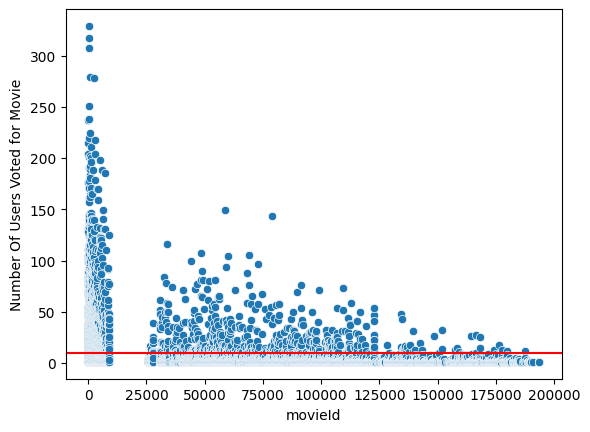

In [41]:
#Visualizing thresholds used to remove noise from data

plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'movieId', data = numberOf_user_voted_for_movie)
plt.axhline(y=10,color='r')
plt.ylabel('Number Of Users Voted for Movie')

Text(0, 0.5, 'Number Of Movies rated by user')

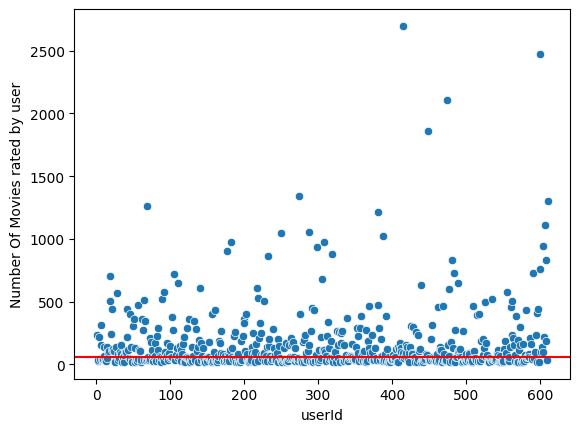

In [42]:
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'userId', data = numberOf_movies_voted_by_user)
plt.axhline(y=60,color='r')
plt.ylabel('Number Of Movies rated by user')

In [43]:
data = pd.pivot(index = 'movieId',columns = 'userId', data = df_ratings, values ='rating')
data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data.fillna(0,inplace = True)
data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
data_final = data.loc[numberOf_user_voted_for_movie[numberOf_user_voted_for_movie['rating'] > 10]['movieId'],:]
data_final = data_final.loc[:,numberOf_movies_voted_by_user[numberOf_movies_voted_by_user['rating'] > 60]['userId']]
data_final.shape

(2121, 334)

In [46]:
data_final

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Dealing with sparsity

from scipy.sparse import csr_matrix
csr_data = csr_matrix(data_final.values)
data_final.reset_index(inplace=True)

In [48]:
data_final

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2117,176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2118,177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,179819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#using knn and writing a function to get list of recommended movies

from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(csr_data)
def get_movie_recommendation(movie_name):
    n= 10
    movie_list = df_movies[df_movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId'] #movieId
        movie_idx = data_final[data_final['movieId'] == movie_idx].index[0] #userId acc to movieId
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze(),distances.squeeze())),key=lambda x: x[1])[1::1]
        recommend = []
        recommend2 = []
        for val in rec_movie_indices:
            movie_idx = data_final.iloc[val[0]]['movieId']
            idx = df_movies[df_movies['movieId'] == movie_idx].index
            recommend.append(df_movies.iloc[idx]['title'].values[0])
            recommend2.append(val[1])         
        df1 = pd.DataFrame(recommend)
        df2 = pd.DataFrame(recommend2)
        df = pd.concat([df1,df2],axis = 'columns')
        df.columns = ['Title','Distance']
        df.set_index('Distance',inplace = True)
        return df1
    else:
        return "No movies found. Please check your input"


### Recommendations from this model:

In [50]:
#get top 10 recommendations
get_movie_recommendation('Iron Man 2')

,0
0,X-Men: First Class
1,"Avengers, The"
2,Iron Man
3,Guardians of the Galaxy
4,Iron Man 3
5,Captain America: The Winter Soldier
6,Scott Pilgrim vs. the World
7,Ant-Man
8,Sherlock Holmes
9,"Amazing Spider-Man, The"


## 2) Content Based model using TF-IDF Vectorizer

In [51]:
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [52]:
content_data = df_movies[['title','genres']]
content_data = content_data.astype(str)
content_data['content'] = content_data['title'] + ' ' + content_data['genres']
content_data = content_data.reset_index()
indices = pd.Series(content_data.index, index=content_data['title'])
content_data.head()


,index,title,genres,content
0,0,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Toy Story ['Adventure', 'Animation', 'Children..."
1,1,Jumanji,"['Adventure', 'Children', 'Fantasy']","Jumanji ['Adventure', 'Children', 'Fantasy']"
2,2,Grumpier Old Men,"['Comedy', 'Romance']","Grumpier Old Men ['Comedy', 'Romance']"
3,3,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Waiting to Exhale ['Comedy', 'Drama', 'Romance']"
4,4,Father of the Bride Part II,['Comedy'],Father of the Bride Part II ['Comedy']


In [53]:
#Convert the data to a matrix of TF-IDF features

tfidf = TfidfVectorizer(stop_words='english')
# Remove stopwords

tfidf_matrix = tfidf.fit_transform(content_data['genres'])

# Shape of tfidf_matrix
tfidf_matrix.shape

(9742, 23)

In [54]:
print(tfidf_matrix)

  (0, 8)	0.482990142708577
  (0, 4)	0.26758647689140014
  (0, 3)	0.5048454681396087
  (0, 2)	0.5162254711770092
  (0, 1)	0.41684567364693936
  (1, 8)	0.5936619434123594
  (1, 3)	0.620525172745643
  (1, 1)	0.5123612074824268
  (2, 18)	0.8210088907493954
  (2, 4)	0.5709154064399099
  (3, 7)	0.46640480307738325
  (3, 18)	0.726240982959826
  (3, 4)	0.5050154397005037
  (4, 4)	1.0
  (5, 20)	0.5420423542868653
  (5, 5)	0.6359470441562756
  (5, 0)	0.5493281743985542
  (6, 18)	0.8210088907493954
  (6, 4)	0.5709154064399099
  (7, 3)	0.7711121633813997
  (7, 1)	0.6366993258087036
  (8, 0)	1.0
  (9, 20)	0.5457299419583338
  (9, 0)	0.5530653284926609
  (9, 1)	0.6295217016667962
  :	:
  (9731, 0)	0.4127296517002463
  (9731, 4)	0.30157046584177355
  (9731, 1)	0.4697858630458896
  (9732, 9)	0.48136743695078876
  (9732, 19)	0.48136743695078876
  (9732, 0)	0.39038039438445316
  (9732, 4)	0.28524046407869114
  (9732, 2)	0.5502833875552382
  (9733, 7)	0.43179372819853856
  (9733, 2)	0.9019723811117537
  

In [55]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print(cosine_sim)

[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


In [56]:
cosine_sim.shape

(9742, 9742)

In [57]:
#Function to return a list of movies to be recommended

def get_content_based_recommendations(title):
    idx = indices[title]
    similarity=cosine_sim
    n_sim=10
    # Get the pairwsie similarity scores of all movies with given movie
    sim_scores = list(enumerate(similarity[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the n_sim most similar movies
    if n_sim > 0:
        n = n_sim + 1
        sim_scores = sim_scores[1:n]
    else:    
        sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]

    # Return the n_sim most similar movies
    recomm_movies_content_based=list(content_data['title'].iloc[movie_indices])
    recs2=[]
    for mov in recomm_movies_content_based:
        recs2.append(mov)
    recommendations_content_based=pd.DataFrame(recs2)
    return recommendations_content_based

### Recommendations from this model:

In [58]:
#get top 10 recommendations

recomm_movies_content_based = get_content_based_recommendations('Iron Man 2')
recomm_movies_content_based 

,0
0,"Matrix Revolutions, The"
1,Spider-Man 3
2,Iron Man 2
3,G.I. Joe: Retaliation
4,Star Wars: Episode II - Attack of the Clones
5,Spider-Man 2
6,Superman Returns
7,Star Trek
8,Transformers: Revenge of the Fallen
9,Avatar


## 3) User Based model using Cosine Similarity

In [59]:
#finding count and mean of ratings for all movies

movies_ratings['count'] = 1
data_pivot_for_count_rating = movies_ratings.drop(['userId'], axis = 'columns').pivot_table(index = ['title'], aggfunc = {'count': 'sum', 'rating': 'mean'})
data_pivot_for_count_rating = data_pivot_for_count_rating.sort_values(by = ['count'], ascending = False)
data_pivot_for_count_rating

,count,rating
title,,
Forrest Gump,329,4.164134
"Shawshank Redemption, The",317,4.429022
Pulp Fiction,307,4.197068
"Silence of the Lambs, The",279,4.161290
"Matrix, The",278,4.192446
...,...,...
Electroma,1,1.000000
Electra Glide in Blue,1,3.500000
Playing It Cool,1,2.000000


In [60]:
movie_data = movies_ratings.drop(['count'], axis = 'columns').pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
movie_data

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# Define Cosine similarity
def calculate_cosine_similarity(x1, x2):
    numerator = np.dot(np.where(np.isnan(x1), 0, x1), np.where(np.isnan(x2), 0, x2))
    x1_squared = np.dot(np.where(np.isnan(x1), 0, x1), np.where(np.isnan(x1), 0, x1))
    x2_squared = np.dot(np.where(np.isnan(x2), 0, x2), np.where(np.isnan(x2), 0, x2))
    denominator = np.sqrt(x1_squared * x2_squared)
    return numerator / denominator
function_dict = {}
function_dict['cosine'] = calculate_cosine_similarity
list_userId = movie_data.index

In [62]:
def recommend_movie_by_similar_user(user, accept_rating = 4.5, movies_data = df_movies):
    method = 'cosine'
    n_recommend = 10
    
    # initial rating correlation dictionary and recommend movieId list
    rating_simility = {}
    recommend_movieId = []
    
    # calculate rating correlation (all users)
    for userId in list_userId:
        rating_simility[userId] = function_dict[method](movie_data.loc[user, :], movie_data.loc[userId, :])
        
    # pick most similar userId
    i = 0
    while len(recommend_movieId) < n_recommend:
        i += 1
        most_similar_userId = sorted(rating_simility, key = rating_simility.get, reverse  = True)[i]
        most_similar_userId_rating = movie_data.loc[most_similar_userId,:]
        rating_list = sorted(pd.Series(np.where(np.isnan(most_similar_userId_rating), 0, most_similar_userId_rating)).unique(), reverse = True)
        for rate_score in rating_list:
            if rate_score >= accept_rating:
                max_rating_movieId = list(most_similar_userId_rating[most_similar_userId_rating == rate_score].index)
                recommend_movieId.extend([movieid for movieid in max_rating_movieId if np.isnan(movie_data.loc[user, movieid])])
                if len(recommend_movieId) >= n_recommend:
                    break
            else:
                break

    movies_data_pivot = movies_data.set_index(['movieId'])
    recommend_movies = list(movies_data_pivot.loc[recommend_movieId[:n_recommend], 'title'])
    print('recommended movies for user %d:\n' %(user))
    recommend_movies_for_user=pd.DataFrame(recommend_movies)
    return recommend_movies_for_user

### Recommendations from this model:

In [63]:
recommend_movie_by_similar_user(user = 132)

recommended movies for user 132:



,0
0,Meet Me in St. Louis
1,Cat on a Hot Tin Roof
2,Sophie's Choice
3,Dracula (Bram Stoker's Dracula)
4,Princess Mononoke (Mononoke-hime)
5,"Notebook, The"
6,"Sea Inside, The (Mar adentro)"
7,Black Swan
8,"Skin I Live In, The (La piel que habito)"
9,50/50
